## Test the energy conservation between pupil and focal plane
With astropy.unit to get the right units <3
We import pupil, field, detector and propagator to test the energy conservation between entrance pupil and detector.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fiatlux.field import Field
from fiatlux.source import Source
from fiatlux.pupil import Pupil
from fiatlux.detector import Detector
from fiatlux.propagator import Propagator

import astropy.units as u
import astropy.constants as C

field_size = 256
telescope_diameter = 0.10
source = Source(magnitude=7)

field = Field(source=source, field_size=field_size, verbose=False)
print(field)

pupil = Pupil(
    field_size=field_size,
    aperture_shape="circular",
    aperture_size=telescope_diameter,
)
print(pupil)

camera = Detector(
    field_size=field_size,
    display_intensity=False,
    exposure_time=0.15,
    noise=True,
    readout_noise_variance=3,
    dark_current=0.5,
    sensitivity=1,
    quantum_efficiency=0.67,
    bitdepth=16,
    offset=2432,
)
print(camera)

<field>
  * field_size : 256.0 pix
  * scale : None
  * wavelength : 5.5e-07 m
<pupil>
  * field_size : 256 (px)
  * scale : 640.0 pix / m (px/m)
  * aperture_size : 0.1 m (m)
<detector>
  * field_size : 256
  * camera_name : Default camera
  * readout_noise_variance : 3.0 electron
  * dark_current : 0.5 electron / s
  * offset : 2432.0 adu
  * bitdepth : 16
  * sensitivity : 1.0 adu / electron


We decide to make a unitary pupil, i.e. $\sum_x \sum_y \left| I(x,y) \right|^2 dx dy = 1$ so that at the end, when the light goes on the detector, and in order to get the number of photon on each pixel, we only got to multiply the pixels' values by $n_\gamma = f_\gamma \times t_{\text{exp}} \times S_{\text{pupil}}$ (eq.1) the number of photon collected by the pupil ($S_{\text{pupil}}$ is the collecting surface, $f_\gamma$ if the photon flux in $[\gamma.\text{m}^{-2}.\text{s}^{-1}]$ and $T_\lambda$.

The photon flux $f_\gamma$ is calculated from the magnitude of the source using Vega magnitudes as $f_\gamma = f_\gamma^{\text{Vega}} \times 10^{-m/2.5}$. The values have been copied from OOPAO Photometry class.

The integral of the whole field after the pupil must then be equal to $1$.

In [2]:

print(
    f"Energy of the whole field before pupil : {np.sum(np.abs(field.complex_amplitude)**2)} (equal to {field.field_size}² = {field.field_size**2})\n"
)

# Going through the pupil
field * pupil

print(
    f"Integrated flux calculated after pupil on the field's complex amplitude {np.sum(np.abs(field.complex_amplitude)**2)}"
)

Energy of the whole field before pupil : 65536.0 (equal to 256.0 pix² = 65536.0 pix2)

Integrated flux calculated after pupil on the field's complex amplitude 0.9999999999999999


After the pupil, if the field is not obstructed or dimmed, the energy remains unitary.

In [3]:
# Propagation to the camera
field > camera

print(
    f"Integrated flux @ camera computed on the field : {np.sum(np.abs(field.complex_amplitude)**2)}"
)

print(
    f"Integrated flux @ camera computed on the camera : {np.sum(np.abs(camera.complex_amplitude)**2)}"
)

Integrated flux @ camera computed on the field : 1.0000000000000002
Integrated flux @ camera computed on the camera : 1.0000000000000002


When the field arrive onto a detector, the property dectector._number_photon is calculated using (eq.1). We check that everything is right there.

In [4]:
print(f"source.photon_flux is {source.photon_flux}")

print(f"It gives following eq.1: {field._source.photon_flux} x {camera._exposure_time} x {pupil._surface} = {field._source.photon_flux * camera._exposure_time * pupil._surface} in the detector plane.")

print(f"Validated with the mesured integral of the noise-free intensity : {np.sum(np.abs(camera.intensity))}")

source.photon_flux is 14212357.43239586 ph / (s m2)
It gives following eq.1: 14212357.43239586 ph / (s m2) x 0.15 s x 0.007853981633974483 m2 = 16743.539137427673 ph in the detector plane.
Validated with the mesured integral of the noise-free intensity : 16743.539137427677 ph


We can then display intensity, both with and without noise.

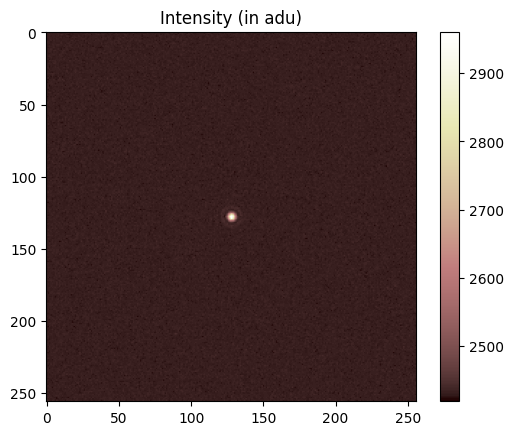

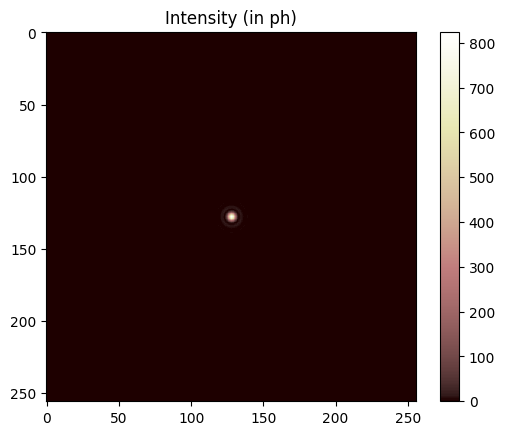

In [5]:
camera.disp_intensity_noise()
camera.disp_intensity()

## Extended source

We now integrate the concept of extended source by specifying it at the creation of the Source object. We give as en entry the [x,y] pairs of the path in the focal plane. In our code, a tilt angle of $2\pi/\text{N}$ (where $N=\text{field\_size}$) give a focal plane displacement of 1 pixel.

In [6]:
field_size = 256
telescope_diameter = 0.10

# build satellite trail
trail_sampling = 100
# 1 px in the focal plane is 2π/field_size rad. in the pupil plane
x_start, x_end = [-50, 50]
y_start, y_end = [-10, 20]
satellite_trail = [
    [x, y]
    for x, y in zip(
        np.linspace(
            start=(2 * np.pi / field_size) * x_start,
            stop=(2 * np.pi / field_size) * x_end,
            num=trail_sampling,
        ),
        np.linspace(
            start=(2 * np.pi / field_size) * y_start,
            stop=(2 * np.pi / field_size) * y_end,
            num=trail_sampling,
        ),
    )
]

source = Source(
    type="extended_object", incidence_angles_list=satellite_trail, magnitude=7
)

field = Field(source=source, field_size=field_size, verbose=False)

pupil = Pupil(
    field_size=field_size,
    aperture_shape="circular",
    aperture_size=telescope_diameter,
)

camera = Detector(
    field_size=field_size,
    display_intensity=False,
    exposure_time=0.15,
    noise=True,
    readout_noise_variance=3,
    dark_current=0.5,
    sensitivity=1,
    quantum_efficiency=0.67,
    bitdepth=16,
    offset=2432,
)

print(f"We ensure that the field size is [{field.field_size}, {field.field_size}, {trail_sampling}] looking at the complex amplitude shape : {field._complex_amplitude.shape}")


We ensure that the field size is [256.0 pix, 256.0 pix, 100] looking at the complex amplitude shape : (256, 256, 100)


We finally check that the number of photon is right on the detector (on the noise-free image).

Calculated number of photon using photon flux and integration time 16743.539137427673 ph
is equal to the integrated intensity over the detector 16743.539137427677 ph


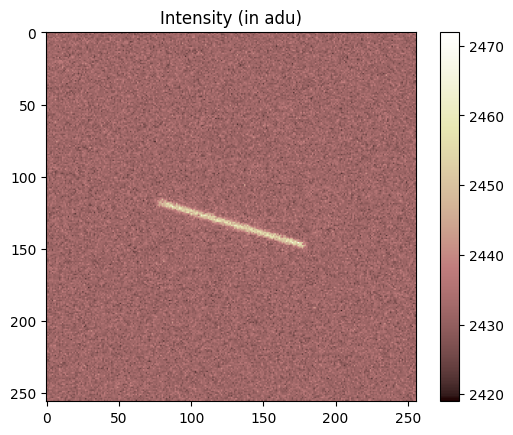

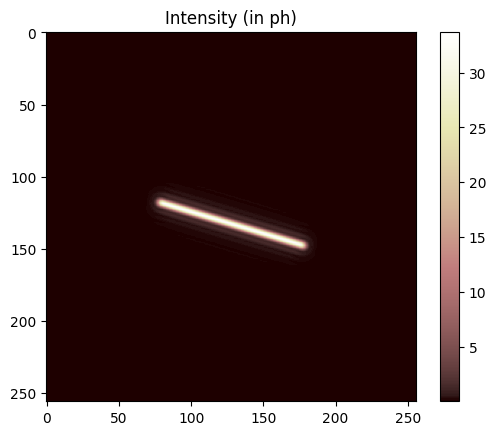

In [7]:
# propagate the field up to the camera
field * pupil > camera

print(
    f"""Calculated number of photon using photon flux and integration time {field._source.photon_flux * camera._exposure_time * pupil._surface}
is equal to the integrated intensity over the detector {np.sum(camera.intensity)}"""
)

camera.disp_intensity_noise()
camera.disp_intensity()